# Stochastic LCA

This is the fifth notebook of a series of 5 (see below the names of full list) intended to teach you the functionalities of the pyhton-based LCA software Brightway 2.5 (BW25) that you will use to carry out your group assignment. For a more nuanced undertsanding of the principles and working mechanisms of BW25 you are referred to [its documentation](https://docs.brightway.dev/en/latest/index.html).

**Full list of notebooks of the series:**
- 1.Getting started
- 2a.Background
- 2b.Foreground
- 3.StaticLCA
- 4.StochasticLCA

## Pre-requesites:
- Having read the tutorial _Computational Settings and Guidelines_ that you can find on Canvas -> [Module 'General documents & Information'](https://canvas.utwente.nl/courses/15132/modules#:~:text=General%20documents%20%26%20information-,General,-documents%20%26%20information)
- Having installed Brightway25 and all relevant packages (make sure to do so in the correct virtual environment) and eventually having had a first contact with its documentation.
- Knowledge of the foundations of life cycle assessment (LCA). If you did not attended the Lecture 3- Pavement Life cycle assessment (LCA) or need a refresher, please have a look at its slides that you can find on Canvas.
- Access to the ecoinvent database version 3.9.1.
- Acess to the foreground database defined in the excel file 'Foreground.xlsx'
- Having gone through the previous notebooks.
- Familiarity with the Python programming language and the Jupyter Lab environment. However, this is **not** a hard requirement since most methods are quite intuitive and will be explained throughput the tutorial. Nevertheless, In case you are a total beginner, or need a refresher, please read the tutorial _Computational Settings and Guidelines_ that you can find on Canvas -> [Module 'General documents & Information'](https://canvas.utwente.nl/courses/15132/modules#:~:text=General%20documents%20%26%20information-,General,-documents%20%26%20information)
  

## Learning Objectives
- Learn how uncertainty is represented in exchanges
- Learn how to perform a stochastic LCA
- Learn how to perform a GSA based on the results of the stochastic LCA

 
## Content

[4.1. STEP 1: Uncertainty Characterization <br>](#Step1)
[4.2. STEP 2: Sample generation <br>](#Step2)
[4.3. STEP 3: Static (i.e., deterministic) LCA <br>](#Step3)
[4.4. STEP 4: Adding Uncertainties <br>](#Step4)
[4.5. STEP 5: Stochastic LCA <br>](#Step5)
[4.6. STEP 6: Global Sensitivity Analysis <br>](#Step5)


In [18]:
# Import scientific packages
from IPython.display import display
import pandas as pd
import numpy as np
import scipy as sp
from pprint import pprint
from tqdm import autonotebook
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.collections as clt
from sklearn import cluster, mixture
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import math

# Import BW25 packages.
import bw2analyzer as bwa
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import bw_processing as bwp
import pandas as pd
from bw2data.query import Filter, Query


In [19]:
#Importing the variables with the project name and background db
from project_details import ei_name, project_name

In [20]:
# set the selected project as the current project
bd.projects.set_current(project_name)
bd.databases

Databases dictionary with 3 object(s):
	asphalt
	biosphere3
	ecoinvent-391-cutoff

In [21]:
# Is the background database name the same as the one we wrote in `project_details.py`?
assert ei_name in bd.databases

As already done in the previous notebooks, let's define and assign the name of the foreground database to a variable called "fg_name".
The name must be equal to the content of the cell B1 in the excel file "Foreground.xlsx"

In [22]:
fg_name = "asphalt"

In [23]:
fgdb = bd.Database(fg_name)

## 4.1. STEP 1: Uncertainty Characterization <a name="Step1"></a>

In this example, we will consider the transport distance of materials to the asphalt plant in A2, the transport distance of the asphalt mixtures from the asphalt plant to the construction site in A4, and the diesel consumption of the machinery used for construction in A5 as uncertain parameters. The foreground file already provides uncertainty information for each of these parameters (associated with activities exchanges). 


In [24]:
# List that will store tuples with info about the uncertain parameters (associated with activity exchanges)
uncertain_parameters = []

### Transport distances in A2

The first step consists of identifying and storing in a list all activities that have 'production and transport' in the name

In [25]:
transport_a2 = fgdb.search("production and transport")
transport_a2

['bitumen, production and transport' (kilogram, NL, None),
 'weak filler, production and transport' (kilogram, NL, None),
 'other fillers, production and transport' (kilogram, NL, None),
 'crushed stone, production and transport' (kilogram, NL, None),
 'modified bitumen, production and transport' (kilogram, NL, None),
 'crushed sand, production and transport' (kilogram, NL, None),
 'natural sand, production and transport' (kilogram, NL, None),
 'drip resistant material, production and transport' (kilogram, NL, None)]

In the foreground database (excel file) provided in the previous lecture, the exchange 'market for transport, freight, lorry, unspecified' in the activities 'bitumen, production and transport' and 'modified bitumen, production and transport' had the same comment (i.e., 'A2_bitumen_t'). This would generate an error in the upcoming steps, as the name assigned in "comments" is used to identify the exchanges. Thus, if the same name is used for multiple exchanges, the upcoming calculations are unable to track the exchanges. Therefore, we have to change the comment in one of the exchanges mentioned before. Let's change it in the activity 'modified bitumen, production and transport'.

In [26]:
# Search and select the activity we are interested in
mod_bitumen = fgdb.search("modified bitumen, production and transport")[0] 

# Store in a list all exchanges of the activity above and select the exchange 'market for transport, freight, lorry, unspecified'.
mod_bitumen_transport = [exchange for exchange in mod_bitumen.exchanges()][2] # The exchange we want is the third in the list, thus we will use [2] to select it and store it in a variable (mod_bitumen_transport). Remember, python uses 0-index  

# Here we convert the content of the variable into a dictionary
mod_bitumen_transport.as_dict()


{'name': 'market for transport, freight, lorry, unspecified',
 'reference product': 'transport, freight, lorry, unspecified',
 'location': 'RER',
 'amount': 0.15,
 'unit': 'ton kilometer',
 'database': 'ecoinvent-391-cutoff',
 'type': 'technosphere',
 'categories': ('(unknown)',),
 'comments': 'A2_modbitumen_t',
 'scenario': ('3', '4'),
 'uncertainty_type': 2,
 'loc': -1.8971199848858813,
 'scale': 0.3474550330618338,
 'input': ('ecoinvent-391-cutoff', 'd6655a43e0d3a5f786929ade5064e0fd'),
 'output': ('asphalt', 'modified_bitumen')}

In [27]:
#Define the new name for the comment by using the dictionary key 'comments'
mod_bitumen_transport['comments'] = 'A2_modbitumen_t'

#Save the changes previously made in 'comments'
mod_bitumen_transport.save()

In [28]:
#Display the content of the dictionary associated with the exchange
mod_bitumen_transport.as_dict()


{'name': 'market for transport, freight, lorry, unspecified',
 'reference product': 'transport, freight, lorry, unspecified',
 'location': 'RER',
 'amount': 0.15,
 'unit': 'ton kilometer',
 'database': 'ecoinvent-391-cutoff',
 'type': 'technosphere',
 'categories': ('(unknown)',),
 'comments': 'A2_modbitumen_t',
 'scenario': ('3', '4'),
 'uncertainty_type': 2,
 'loc': -1.8971199848858813,
 'scale': 0.3474550330618338,
 'input': ('ecoinvent-391-cutoff', 'd6655a43e0d3a5f786929ade5064e0fd'),
 'output': ('asphalt', 'modified_bitumen')}

Next, we need to store information about the uncertainty of the exchanges (considered in the activities). Specifically, we are interested in the fields 'comments', 'uncertainty_type', 'loc' and 'scale' defined in the foreground and ecoinvent databases. Their meaning is as follows:

- `uncertainty_type`: type of probability distribution function (pdf) that the exchange follows. In our foreground database, the exchanges have an uncertainty type = 2, indicating it is a `lognormal`  distribution. This is the type of pdf you should consider. A value equal to 0 means no uncertainty. More info about the uncertainty type and respective code can be found [here](https://stats-arrays.readthedocs.io/en/latest/).
- `loc`,`scale`:  parameters of the probability distribution function considered. In the case of the lognormal they are respectively the mean and the standard deviation of the underlying normal distribution. The natural logarithm of the _median_ of the lognormal distribution is equal to the median (=mean) of the underlying distribution.
Considering the deterministic exchange amount `amount` to be the median, we have `loc` = `ln('amount')`. You can see this formula being used in the foreground database (excel file) 
As far as the standard deviation (`scale`) is concerned, the value is obtained from the basic and additional uncertainty, defined according to the pedigree matrix.
For instance, if you look at the exchange 'diesel, burned in building machine' considered in the activity 'asphalt, construction', you will see that the `loc` value is 0,0374166. This value is the square root of the sum of the basic uncertainty (0,0006) and the additional uncertainty (0,0006 + 0 + 0,0002 + 0 + 0) corresponding to the example given in the uncertainty modelling lecture.


To store the info explained above we run the cell below:

In [29]:
uncertain_parameters = [] #list that stores the info about the uncertain parameters associated with exchanges

for transport in transport_a2:
    exchanges = transport.technosphere()
    for exchange in exchanges:
        exchanges_dict = exchange.as_dict()
        if "comments" in exchanges_dict:
            parameter = exchanges_dict["comments"]
            distribution = exchanges_dict["uncertainty_type"]
            loc = exchanges_dict["loc"]
            scale = exchanges_dict["scale"]
            uncertain_parameters.append((parameter, 
                    distribution, 
                    loc,
                    scale))
uncertain_parameters

[('A2_bitumen_t', 2, -1.3862943611198906, 0.3474550330618338),
 ('A2_weakfiller_t', 2, -1.995100393246085, 0.3474550330618338),
 ('A2_ownmaterial_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_ownmaterial_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedstone_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedstone_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_modbitumen_t', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedsand_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_naturalsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_naturalsand_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_dripresistantmaterial_t', 2, -1.731605546408308, 0.3474550330618338)]

### Transport distances in A4

Execute the same procedure but for activities that have 'asphalt, transport to site' in the name

In [30]:
transport_a4 = fgdb.search("asphalt, transport to site")
transport_a4

['asphalt, transport to site' (kilogram, NL, None)]

In [31]:
for transport in transport_a4:
    exchanges = transport.technosphere()
    for exchange in exchanges:
        exchanges_dict = exchange.as_dict()
        if "comments" in exchanges_dict:
            parameter = exchanges_dict["comments"]
            distribution = exchanges_dict["uncertainty_type"]
            loc = exchanges_dict["loc"]
            scale = exchanges_dict["scale"]
            uncertain_parameters.append((parameter, 
                    distribution, 
                    loc,
                    scale))
uncertain_parameters

[('A2_bitumen_t', 2, -1.3862943611198906, 0.3474550330618338),
 ('A2_weakfiller_t', 2, -1.995100393246085, 0.3474550330618338),
 ('A2_ownmaterial_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_ownmaterial_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedstone_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedstone_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_modbitumen_t', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedsand_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_naturalsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_naturalsand_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_dripresistantmaterial_t', 2, -1.731605546408308, 0.3474550330618338),
 ('A4_distance_EURO5', 2, -3.402197881995739, 0.3474550330618338),
 ('A4_distance_EURO6', 2, -4.500810170663849, 0.3474550330618338)]

### Diesel consumption in A5

Once again, similar procedure but for activities that have 'asphalt, construction' in the name

In [32]:
construction_a5 = fgdb.search("asphalt, construction")
construction_a5

['asphalt, construction' (kilogram, NL, None)]

In [33]:
for consumption in construction_a5:
    exchanges = consumption.technosphere()
    for exchange in exchanges:
        exchanges_dict = exchange.as_dict()
        if "comments" in exchanges_dict:
            parameter = exchanges_dict["comments"]
            distribution = exchanges_dict["uncertainty_type"]
            loc = exchanges_dict["loc"]
            scale = exchanges_dict["scale"]
            uncertain_parameters.append((parameter, 
                    distribution, 
                    loc,
                    scale))
uncertain_parameters

[('A2_bitumen_t', 2, -1.3862943611198906, 0.3474550330618338),
 ('A2_weakfiller_t', 2, -1.995100393246085, 0.3474550330618338),
 ('A2_ownmaterial_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_ownmaterial_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedstone_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedstone_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_modbitumen_t', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_crushedsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_crushedsand_iv', 2, -0.4155154439616658, 0.3474550330618338),
 ('A2_naturalsand_t', 2, -3.6888794541139363, 0.3474550330618338),
 ('A2_naturalsand_iv', 2, -1.8971199848858813, 0.3474550330618338),
 ('A2_dripresistantmaterial_t', 2, -1.731605546408308, 0.3474550330618338),
 ('A4_distance_EURO5', 2, -3.402197881995739, 0.3474550330618338),
 ('A4_distance_EURO6', 2, -4.500810170663849, 0.3474550330618338),
 ('A5_construction', 2, -4.468892567695543, 0.03741657

## STEP 2: Sample generation <a name="Step2"></a>

Now that we have retrieved the uncertain parameters information, we can proceed to generate our samples.

First, we define a Latin hypercube sampling (LHS) function:

In [34]:
def LHS_generator(inputs, sample_size, seed=None):
    # Determine the number of parameters based on the length of inputs
    num_parameters = len(inputs)

    # Assign random seed (if specified) for reproducibility
    if seed:
        np.random.seed(seed)

    # Initialize an empty array to hold the results
    result = np.empty([sample_size, num_parameters])
    
    # Calculate the interval width for the uniform distribution
    d = 1.0 / sample_size
    
    # Generate samples using uniform distribution within specified ranges
    temp = np.array(
        [
            np.random.uniform(low=sample * d, high=(sample + 1) * d, size=num_parameters)
            for sample in range(sample_size)
        ]
    )

    # Process each parameter to perform Latin Hypercube Sampling for log-normal distribution
    for parameter in range(num_parameters):
        # Shuffle the samples to ensure randomness
        np.random.shuffle(temp[:, parameter])
        
        # Apply the inverse cumulative distribution function (ppf) of the normal distribution
        # then exponentiate to transform to a log-normal distribution
        temp[:, parameter] = np.exp(sp.stats.norm.ppf(temp[:, parameter], loc=inputs[parameter][2], scale=inputs[parameter][3]))
        
        # Fill the result array with processed samples
        for sample in range(sample_size):
            result[sample, parameter] = temp[sample, parameter]

    # Convert result to a DataFrame with column names from the first column of inputs
    column_names = [inputs[i][0] for i in range(num_parameters)]
    result_df = pd.DataFrame(result, columns=column_names)

    return result_df

Once defined the LHS function, we can run it for the  parameters for which we gathered and stored the information about their uncertainty (stored in the list 'uncertain_parameters'). We will consider a sample size equal to 100.

In [35]:
# Run the LHS function for the parameters defined above and a sample size equal to 100:
sample_size = 100
samples = LHS_generator(uncertain_parameters,sample_size)

In [36]:
samples

,A2_bitumen_t,A2_weakfiller_t,A2_ownmaterial_t,A2_ownmaterial_iv,A2_crushedstone_t,A2_crushedstone_iv,A2_modbitumen_t,A2_crushedsand_t,A2_crushedsand_iv,A2_naturalsand_t,A2_naturalsand_iv,A2_dripresistantmaterial_t,A4_distance_EURO5,A4_distance_EURO6,A5_construction
0,0.240731,0.216232,0.019869,0.138912,0.021743,0.872891,0.122734,0.027653,0.762961,0.043439,0.150795,0.112008,0.030365,0.026202,0.011105
1,0.281821,0.123914,0.051548,0.086081,0.024089,0.755842,0.186947,0.028517,0.918257,0.036056,0.226667,0.219473,0.034372,0.009321,0.011182
2,0.233276,0.091316,0.027746,0.098913,0.018666,0.518060,0.193090,0.051159,1.185225,0.028638,0.100683,0.115928,0.022245,0.007538,0.012188
3,0.229853,0.376017,0.035184,0.180262,0.020168,0.468415,0.239835,0.026606,0.437942,0.028503,0.098635,0.130392,0.038701,0.010107,0.012131
4,0.215042,0.184109,0.034811,0.156145,0.021456,0.710235,0.125418,0.033166,0.675800,0.014105,0.194621,0.192025,0.013868,0.007808,0.010770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.228587,0.112126,0.024815,0.152591,0.033539,0.645471,0.161160,0.018130,1.014669,0.037426,0.076267,0.251210,0.040986,0.011616,0.011786
96,0.258381,0.113404,0.029177,0.245454,0.024487,0.584348,0.078774,0.023671,1.317520,0.013137,0.161845,0.356355,0.019776,0.011145,0.011727
97,0.161189,0.105852,0.032948,0.181958,0.017439,1.139782,0.137505,0.021880,0.709870,0.022581,0.202809,0.132206,0.040430,0.010024,0.011213
98,0.209235,0.107758,0.020393,0.166253,0.037528,0.780090,0.166360,0.047834,0.770037,0.015527,0.165122,0.155566,0.024188,0.009111,0.011232


### Link samples to exchanges

Once obtained the samples, we need to link them to the respective exchange. To do so, we need the two functions below (NOTE: you do not have to change something in these functions):

In [37]:
def exchange_coords(exchange):
    """create a tuple with the numerical ids of the input and output activites of an exchange."""
    input_activity = bd.get_activity(exchange["input"])
    output_activity = bd.get_activity(exchange["output"])
    return (input_activity.id, output_activity.id)

In [38]:
def build_coords_sample(activities, samples_df):
    """Build the coords + sample dictionnary for all concerned activities."""
    
    coords_samples_map = {}

    counter = 0

    for activity in activities:
        exchanges = activity.technosphere()
        for exchange in exchanges:
            exchanges_dict = exchange.as_dict()
            if "comments" in exchanges_dict:
                col_name = exchanges_dict["comments"]
                coords = exchange_coords(exchange)
                counter += 1
                print(f"{counter}. {exchange}\n\t 👉 {coords} to {col_name}")
                coords_samples_map[exchange_coords(exchange)] = samples_df[
                    col_name
                ].values  # numpy.ndarray
    return coords_samples_map


Below we will group in a list called 'activities' all activities for which we are going to consider the uncertainties in the exchanges:

In [39]:
# Group activity variables
activities = transport_a2 + transport_a4 + construction_a5
activities

['bitumen, production and transport' (kilogram, NL, None),
 'weak filler, production and transport' (kilogram, NL, None),
 'other fillers, production and transport' (kilogram, NL, None),
 'crushed stone, production and transport' (kilogram, NL, None),
 'modified bitumen, production and transport' (kilogram, NL, None),
 'crushed sand, production and transport' (kilogram, NL, None),
 'natural sand, production and transport' (kilogram, NL, None),
 'drip resistant material, production and transport' (kilogram, NL, None),
 'asphalt, transport to site' (kilogram, NL, None),
 'asphalt, construction' (kilogram, NL, None)]

We can now run the function introduced above using as argument the activities that contain the parameters for which we consider the uncertainties and the samples generated with LHS:

In [40]:
coords_samples_map = build_coords_sample(activities, samples)

1. Exchange: 0.25 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'bitumen, production and transport' (kilogram, NL, None)>
	 👉 (18370, 25951) to A2_bitumen_t
2. Exchange: 0.136 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'weak filler, production and transport' (kilogram, NL, None)>
	 👉 (18370, 25957) to A2_weakfiller_t
3. Exchange: 0.025 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'other fillers, production and transport' (kilogram, NL, None)>
	 👉 (18370, 25955) to A2_ownmaterial_t
4. Exchange: 0.15 ton kilometer 'market for transport, freight, inland waterways, barge' (ton kilometer, RER, None) to 'other fillers, production and transport' (kilogram, NL, None)>
	 👉 (9408, 25955) to A2_ownmaterial_iv
5. Exchange: 0.025 ton kilometer 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None) to 'crushed stone, product

In [41]:
# Prints the dictionnary with the coordinates and vector with the samples.
counter = 0
for k, v in coords_samples_map.items():
    counter +=1
    print(f"{counter}. {k} --array-> {v}")

1. (18370, 25951) --array-> [0.2407306  0.2818213  0.23327626 0.22985282 0.21504215 0.37756883
 0.18171615 0.32213153 0.22413467 0.25255197 0.30317083 0.11463125
 0.36181893 0.27304801 0.25635554 0.37245705 0.2851398  0.15661034
 0.29056603 0.26816546 0.32706594 0.39019653 0.45080815 0.32494084
 0.13202638 0.41012416 0.27694376 0.55251322 0.19504467 0.17538282
 0.40191319 0.20680536 0.27079507 0.23826182 0.44252342 0.19325286
 0.2176583  0.14930909 0.4663402  0.42827967 0.29390586 0.15988078
 0.1070409  0.61780239 0.27007179 0.13767596 0.18469734 0.24571781
 0.24333955 0.15283585 0.20513919 0.24821242 0.24418661 0.22678072
 0.21953348 0.34534654 0.21125969 0.33583467 0.21267771 0.30680795
 0.33482471 0.16848233 0.19672677 0.34355836 0.19009348 0.29425709
 0.31797749 0.26542574 0.16488151 0.31446306 0.25011044 0.28728166
 0.17802893 0.20276274 0.31112379 0.18885453 0.2802809  0.17286467
 0.18338848 0.25917992 0.23529551 0.26154535 0.29897    0.30072727
 0.19928095 0.34837645 0.3541703  

## STEP 3: Static (i.e, deterministic) LCA <a name="Step3"></a>

In this step we are going to perform a static LCA for the product system we are interested in. Let's consider the example 3.4 of the previous notebook. Given that we are already familiar with static LCA, we will abreviate the explanations.

In [42]:
pavement_structure = fgdb.get("pavement_structure_1")

### Functional Unit

In [43]:
functional_unit = {pavement_structure:1}

### LCIA Method

In [44]:
cml_method_gwp = (
    "CML v4.8 2016",
    "climate change",
    "global warming potential (GWP100)",
)

### LCIA scores (i.e. results) calculation

In [45]:
# Create a lca object
a_lca = bc.LCA({pavement_structure: 1}, cml_method_gwp)

In [46]:
a_lca.lci()
a_lca.lcia()
a_lca.score

1295038.759926335

In [47]:
print("The score is {:f} {} for impact category {}".format(a_lca.score, 
                                                 bd.methods.get(cml_method_gwp).get('unit'),
                                                 cml_method_gwp[1]))

The score is 1295038.759926 kg CO2-Eq for impact category climate change


## Step 4: Adding Uncertainties <a name="Step4"></a>

In this setp we are going to add the uncertainty to the exchanges. REMINDER: uncertainties are added to exchanges (not activities).

### LCA using datapackages

Below we are using the method `prepare_lca_inputs`. It has the same argument as that you considered when you created the LCA object above.

In [48]:
indexed_demand, data_objs, remapping_dicts = bd.prepare_lca_inputs({pavement_structure: 1}, cml_method_gwp)

NOTE: there is no need to make changes in the upcoming cells until the heading 'Plot the results'

In [49]:
indexed_demand

{25983: 1}

In [50]:
data_objs

In [51]:
dp_correlated = bwp.create_datapackage(sequential=True)

In [52]:
samples_indices = [coord for coord in coords_samples_map.keys()]
pprint(samples_indices)

[(18370, 25951),
 (18370, 25957),
 (18370, 25955),
 (9408, 25955),
 (18370, 25953),
 (9408, 25953),
 (18370, 25952),
 (18370, 25954),
 (9408, 25954),
 (18370, 25956),
 (9408, 25956),
 (18370, 25958),
 (16115, 25969),
 (8986, 25969),
 (18987, 25970)]


In [53]:
# Prepare the data_array, it must be an array of arrays
samples_values = np.array([coords_samples_map[coord] for coord in samples_indices])
pprint(samples_values)

array([[0.2407306 , 0.2818213 , 0.23327626, ..., 0.1611887 , 0.20923539,
        0.39377984],
       [0.21623182, 0.12391434, 0.09131551, ..., 0.10585167, 0.10775793,
        0.14478889],
       [0.01986937, 0.05154773, 0.02774587, ..., 0.03294828, 0.02039267,
        0.05012438],
       ...,
       [0.03036493, 0.03437164, 0.02224516, ..., 0.04043037, 0.02418754,
        0.026317  ],
       [0.02620164, 0.00932093, 0.00753775, ..., 0.01002429, 0.00911124,
        0.0132706 ],
       [0.01110463, 0.01118218, 0.01218812, ..., 0.01121263, 0.01123151,
        0.01143609]])


In [54]:
dp_correlated.add_persistent_array(
    matrix="technosphere_matrix",
    indices_array=np.array(samples_indices, dtype=bwp.INDICES_DTYPE),
    data_array=samples_values,
    # We flip the signs of the samples
    # to obey bw's convention
    flip_array=np.array([True for _ in range(len(samples_values))]),
)

## Step 5: Stochastic LCA <a name="Step5"></a>

In this step we are going to perform the stochastic LCA considering the uncertainties in the exchanges scrutinized in the previous steps.

### Build the new data objects to re-do the LCA

In [55]:
data_objs.append(dp_correlated)

In [56]:
dp_lca = bc.LCA(demand=indexed_demand, data_objs=data_objs, use_arrays=True)
dp_lca.lci()
dp_lca.lcia()
dp_lca.score

1380691.8549186164

In [57]:
scores = []
for _ in autonotebook.tqdm(range(sample_size)):
    next(dp_lca)
    scores.append(dp_lca.score)

100%|█████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


In [59]:
scores_a = np.array(scores)
scores_a.mean()

1316050.9410746917

In [60]:
scores_a_s = pd.Series(scores_a)
print(scores_a_s)

0     1.342756e+06
1     1.235264e+06
2     1.245242e+06
3     1.263438e+06
4     1.308570e+06
          ...     
95    1.264451e+06
96    1.424782e+06
97    1.313219e+06
98    1.284189e+06
99    1.380692e+06
Length: 100, dtype: float64


### Plot the results
Below we will plot the results of the stochastic LCA. We may want to customize the layout of the plot as you want

/var/folders/16/htgv8kns0w7dsvxmq5d9snzc0000gn/T/ipykernel_6575/4266909328.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='GWP', inner=None, cut=0, bw=0.2, scale='width', orient='h', split=True)
/var/folders/16/htgv8kns0w7dsvxmq5d9snzc0000gn/T/ipykernel_6575/4266909328.py:11: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=df, x='GWP', inner=None, cut=0, bw=0.2, scale='width', orient='h', split=True)


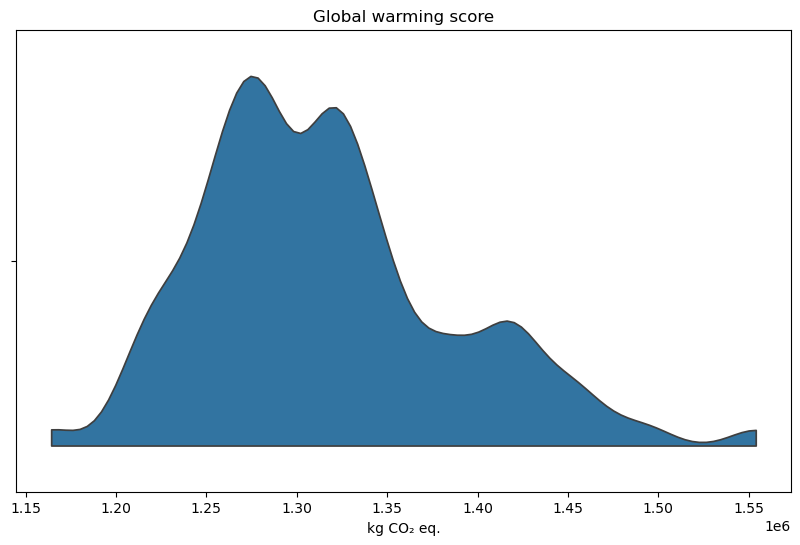

In [61]:
# Sample data as given in the series
data = scores_a_s

# Create a DataFrame from the series
df = pd.DataFrame(data, columns=['GWP'])

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the half violin plot (right side)
sns.violinplot(data=df, x='GWP', inner=None, cut=0, bw=0.2, scale='width', orient='h', split=True)

# Set the title and labels
plt.title("Global warming score")
plt.xlabel("kg CO₂ eq.")  # CO₂ with subscript '2'

# Show the plot
plt.show()

## STEP 6: Global Sensitivity analysis (GSA) <a name="Step6"></a>

In this (and last) step we are going to perfom a GSA using the Extra Trees method. But for this specific product system ,i.e. 'pavement_structure_1', we have to perfom a small operation before we run the Extra Trees  algorithm. This is because we run the LHS function for all exchanges stored in the list 'uncertain_parameters'. However, the activity that contains the exchange for which we defined a new name of 'comments' (i.e., 'A2_modbitumen_t') is not used in the product system 'pavement_structure_1'. Therefore, we have to delete it from the dataframe (named 'samples') that stores the samples created with LHS  for each exchange. We will do that by droping the respective column of the 'samples' dataframe:

In [63]:
samples.drop('A2_modbitumen_t', axis=1, inplace=True)

We can run now the Extra Trees GSA method algorithm

In [64]:
# Extra Trees GSA method algorithm

x = samples.to_numpy()
print(x.size)
y = scores_a_s.to_numpy()

#Extra Trees parameters from Jaza-Roxen and Kwakkel (2018)
t = 100 
m = round(len(x[0])/3)
N = 100
nmin = 5
nleaf = math.sqrt(N) / math.sqrt(1000)

#ExtraTrees regressor function
regr = ExtraTreesRegressor(n_estimators=t, max_features=m, min_samples_split=nmin,
                           min_samples_leaf=nleaf)
regr = regr.fit(x,y)

1400


Below we calculate the Mean Decrease Impurity (MDI) metric for each exchange. An exchange is considered important when it is associated with high MDI values.

In [97]:
mdi = regr.feature_importances_
mdi = pd.DataFrame(mdi, columns=["MDI"])
mdi.index = samples.columns
mdi["MDI normalized"] = mdi["MDI"]/np.max(mdi["MDI"])
mdi

,MDI,MDI normalized
A2_bitumen_t,0.037037,0.333333
A2_weakfiller_t,0.074074,0.666667
A2_ownmaterial_t,0.111111,1.000000
A2_ownmaterial_iv,0.111111,1.000000
A2_crushedstone_t,0.037037,0.333333
A2_crushedstone_iv,0.094250,0.848247
A2_crushedsand_t,0.055556,0.500000
A2_crushedsand_iv,0.111111,1.000000
A2_naturalsand_t,0.018519,0.166667
A2_naturalsand_iv,0.074074,0.666667
